# If run again, change lat_max and lon_max

In [1]:
def investigate_traj(figsize, proj, nb_traj, hfacc_level):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.basemap import Basemap
    import cmocean
    
    fig     = plt.figure(figsize=figsize)
    
    if proj=='ortho':
        m       = Basemap(projection='ortho', lat_0=-90, lon_0=0, resolution="l")
    elif proj=='merc':
        m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-30.,llcrnrlon=150.,urcrnrlon=270.,lat_ts=-60.,resolution='c')
    elif proj=='lamb':
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-60.,rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',lat_1=65.,lon_0=180.)
    
    # Plot all the traj
    for p in nb_traj: 
        xm, ym  = m(LON[:,p], LAT[:,p])
        im      = m.plot(xm, ym, '-', color='orange',linewidth=0.4)
        xm, ym  = m(LON[0,p], LAT[0,p])
        im      = m.plot(xm, ym, '.', color='yellow',linewidth=2.)
        xm, ym  = m(LON[-1,p], LAT[-1,p])
        im      = m.plot(xm, ym, '*', color='r',linewidth=3.)
    
    # Plot the continents thanks to hFacC==0, choose the level : 0=surf, 9=30m
    xm, ym  = m(Xf, Yf)
    im      = m.contourf(xm, ym, hFacC[hfacc_level,...], extend='both', cmap='Greys_r')
    
    # Plot the salinity
    xm, ym  = m(Lon, Lat)
    im      = m.contourf(xm, ym, mean_Salt_30, levels=np.linspace(32.8,35.3,50), extend='both', cmap=cmocean.cm.haline, alpha=0.6)
    cbar    = m.colorbar(im,pad='10%')
    cbar.set_label('Salinity', fontsize =16)
        
    m.drawparallels(np.arange(-80.,-30.,10), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(120.,280.,10), labels=[0, 0, 0, 1])
    #plt.title('10 000 parti, 5 years (hFacC and S at 30 m)', fontsize=18)
    #plt.savefig(path_save + title_save, bbox_inches='tight')

In [2]:
# Functions to save and load variables/data

def pickle_save(name, path, data, verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)
    full_name = (os.path.join(path,name+ '.npy'))


    with open(full_name, 'wb') as f2:
        pickle.dump(data, f2)
    if verbose:
        print('saved at : ',full_name)

def pickle_load(name, path, verbose=True):
    #if not os.path.exists(path):
    #    os.makedirs(path)
    full_name= (os.path.join(path,name+ '.npy'))

    with open(full_name, 'r') as f:
        data=pickle.load(f)

    if verbose:
        print('loaded from : ',full_name)
    return data

In [3]:
def lambert_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(8,8))
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='0.5', lake_color='0.5')
        m.drawparallels(np.arange(-80.,-60.,5), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(160.,210.,5), labels=[0, 0, 0, 1])
        m.drawcoastlines()
       
        m2      = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm2, ym2  = m2(LON, LAT)
        im2     = m2.plot(xm2,ym2,'.', color='k',linewidth=2.)

        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

In [4]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import h5py
from scipy.io import loadmat
from mpl_toolkits.basemap import Basemap
import netCDF4
from scipy import interpolate
import os
import pickle
import cmocean

plot_path_1993_2017='/home/ebent/plots/1993_2017/'
plot_path_2006_2011='/home/ebent/plots/2006_2011/'
plot_path_jup='/home/ebent/plots/2006_2011/jup2/'
load_path='/data/mmazloff/AVISO/'
load_path2='/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
load_path3='/data/soccom/GRID_12/'

In [5]:
# Mercator salinity
mean_Salt_surf = pickle_load('mean_Salt_surf_2', '/data/ebent', verbose=False)
mean_Salt_30     = pickle_load('mean_Salt_30_2', '/data/ebent', verbose=False)
mean_Salt_100   = pickle_load('mean_Salt_100_2', '/data/ebent', verbose=False)
mean_Salt_200   = pickle_load('mean_Salt_200_2', '/data/ebent', verbose=False)
mean_Salt_500   = pickle_load('mean_Salt_500_2', '/data/ebent', verbose=False)

# Mercator temperature
mean_Theta_surf = pickle_load('mean_Theta_surf_2', '/data/ebent', verbose=False)
mean_Theta_30     = pickle_load('mean_Theta_30_2', '/data/ebent', verbose=False)
mean_Theta_100   = pickle_load('mean_Theta_100_2', '/data/ebent', verbose=False)
mean_Theta_200   = pickle_load('mean_Theta_200_2', '/data/ebent', verbose=False)
mean_Theta_500   = pickle_load('mean_Theta_500_2', '/data/ebent', verbose=False)

In [6]:
# Load files
file1 = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

In [7]:
# Mercator grid for salinity
lon_min = 1800
lon_max = 3240
lat_min = 0
lat_max = 1170

lat = file1.variables['lat'][lat_min:lat_max]
lon = file1.variables['lon'][lon_min:lon_max]
Lon, Lat = np.meshgrid(lon,lat)

In [8]:
# This is hFacC for the SOUTHERN HEMISPHERE

file_h = h5py.File(load_path3 + 'grid.mat','r')

hFacC = file_h.get('hFacC')
hFacC = np.array(hFacC)
Xf = file_h.get('XC')
Xf = np.array(Xf)
Yf = file_h.get('YC')
Yf = np.array(Yf)

***

In [9]:
path = '/data/ebent/Octopus/output/10_4parti_2/'

DEP = pickle_load('DEP_10_4', path, verbose=False)
LAT = pickle_load('LAT_10_4', path, verbose=False)
LON = pickle_load('LON_10_4', path, verbose=False)

z = pickle_load('z_10_4', path, verbose=False)
y = pickle_load('y_10_4', path, verbose=False)
x = pickle_load('x_10_4', path, verbose=False)

In [10]:
# On selectionne la bonne taille de hFacC == taille de "bigger domain"

load_path2= '/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
file1     = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

lon_min   = 1440 
lon_max   = 3240 # devrait être changé à 3241 si je run ce script again
lat_min   = 0 
lat_max   = 1023 # devrait être changé à 1024 si je run ce script again

YC        = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -40,05
XC        = file1.variables['lon'][lon_min:lon_max] # de 120,04 a 270,04

hfacc = hFacC[:, lat_min:lat_max, lon_min:lon_max]

# Plots

## T and S

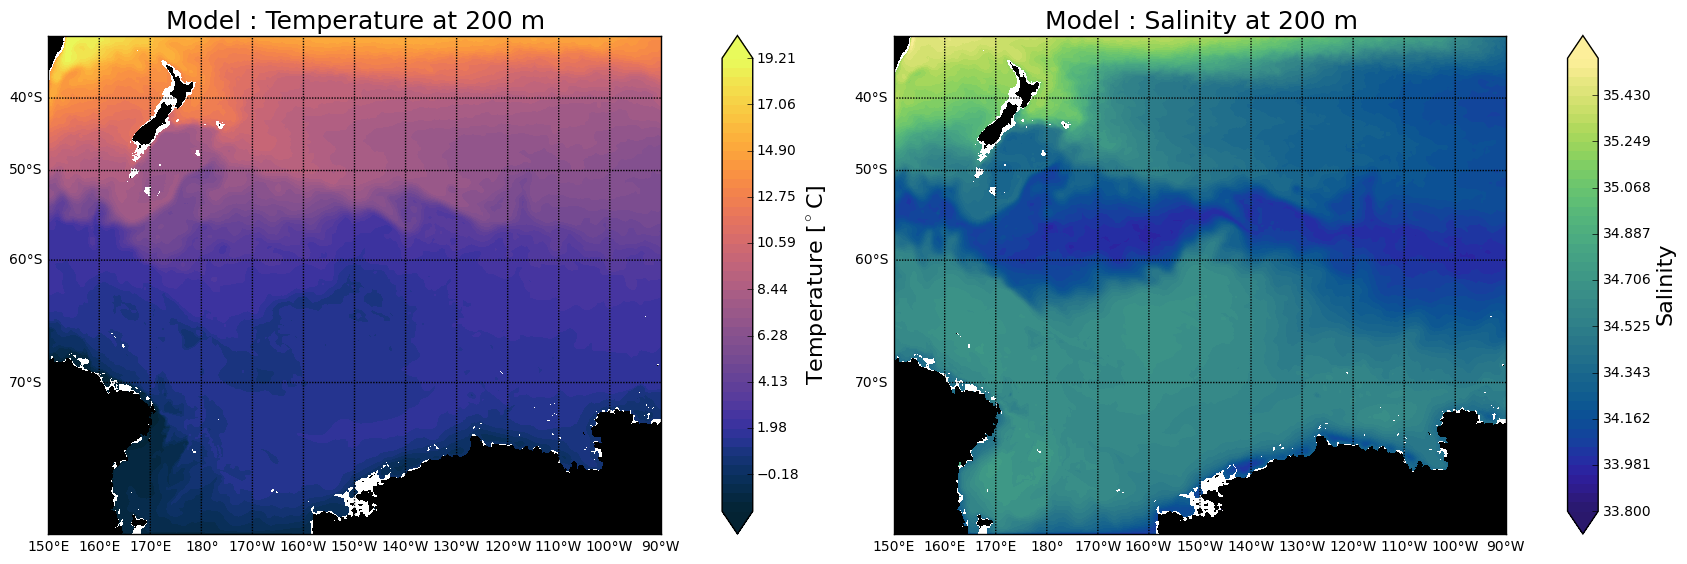

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap



fig     = plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
#m       = Basemap(projection='ortho', lat_0=-90, lon_0=0)#, resolution="f")
m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-30.,llcrnrlon=150.,urcrnrlon=270.,lat_ts=-60.,resolution='c')
#m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-60.,rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',lat_1=65.,lon_0=180.)
   
# Plot the salinity
xm, ym  = m(Lon, Lat)
im      = m.contourf(xm, ym, mean_Theta_200, levels=np.linspace(mean_Theta_200.min(),mean_Theta_200.max(),50), extend='both', cmap=cmocean.cm.thermal)
cbar    = m.colorbar(im,pad='10%')
cbar.set_label('Temperature [$^\circ$C]', fontsize =16)
#cs      = m.contour(xm, ym, mean_Theta_200, levels=np.arange(-1,20,2), linewidths=1, alpha=0.8, colors='k')
#plt.clabel(cs, inline=True, fontsize=13, fmt='%i')


# Plot the continents thanks to hFacC==0, choose the level : 0=surf, 9=30m
xm, ym  = m(Xf, Yf)
im      = m.contourf(xm, ym, hFacC[9,...], levels=np.linspace(0,1,2), extend='both', cmap='Greys_r')

m.drawparallels(np.arange(-80.,-30.,10), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(120.,280.,10), labels=[0, 0, 0, 1])
plt.title('Model : Temperature at 200 m', fontsize=18)
#plt.savefig(path_save + title_save, bbox_inches='tight')

plt.subplot(1,2,2)

#fig     = plt.figure(figsize=(14,10))
#m       = Basemap(projection='ortho', lat_0=-90, lon_0=0)#, resolution="f")
m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-30.,llcrnrlon=150.,urcrnrlon=270.,lat_ts=-60.,resolution='l')
#m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-60.,rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',lat_1=65.,lon_0=180.)
   
# Plot the salinity
xm, ym  = m(Lon, Lat)
im      = m.contourf(xm, ym, mean_Salt_200, levels=np.linspace(mean_Salt_200.min(),mean_Salt_200.max(),50), extend='both', cmap=cmocean.cm.haline)
cbar    = m.colorbar(im,pad='10%')
cbar.set_label('Salinity', fontsize =16)

# Plot the continents thanks to hFacC==0, choose the level : 0=surf, 9=30m
xm, ym  = m(Xf, Yf)
im      = m.contourf(xm, ym, hFacC[9,...], levels=np.linspace(0,1,2), extend='both', cmap='Greys_r')


m.drawparallels(np.arange(-80.,-30.,10), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(120.,280.,10), labels=[0, 0, 0, 1])
plt.title('Model : Salinity at 200 m', fontsize=18)
#plt.savefig(path_save + title_save, bbox_inches='tight')

# 10 000 particles

# Experiment 10_4parti_1 

/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


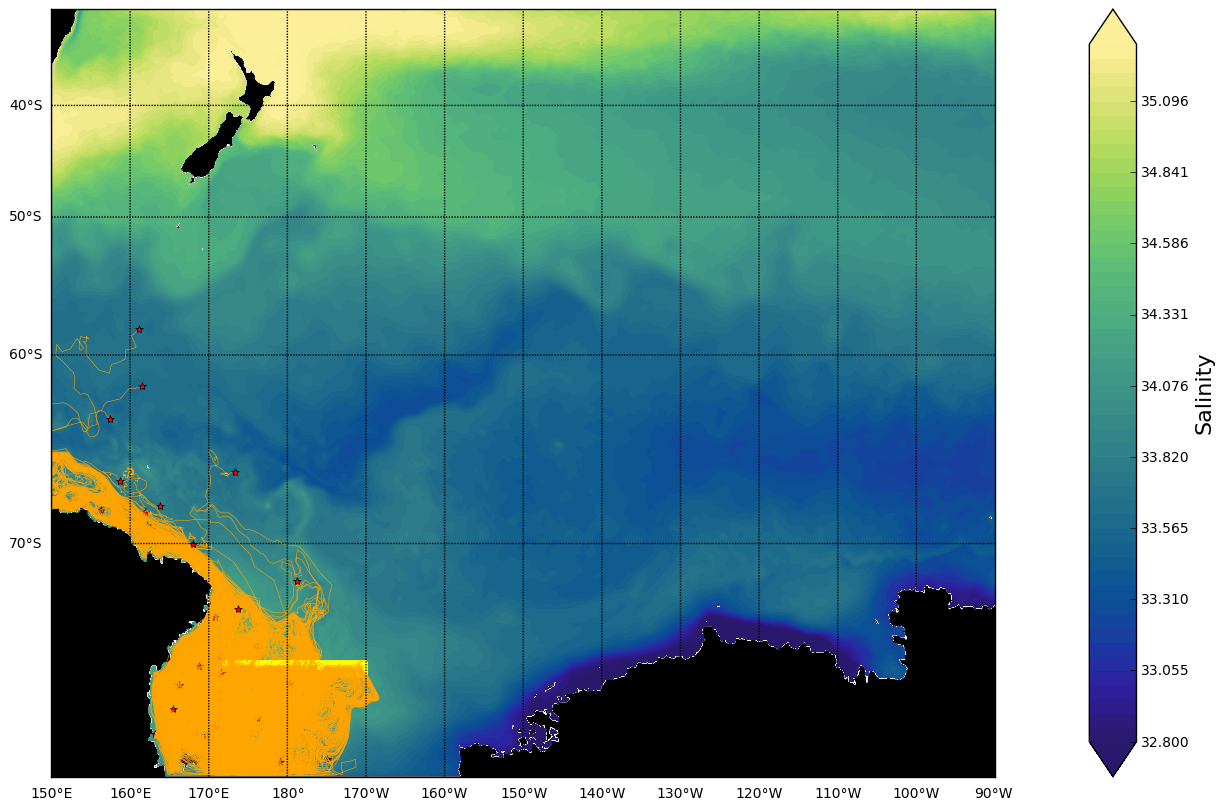

In [12]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(1000), hfacc_level=9)

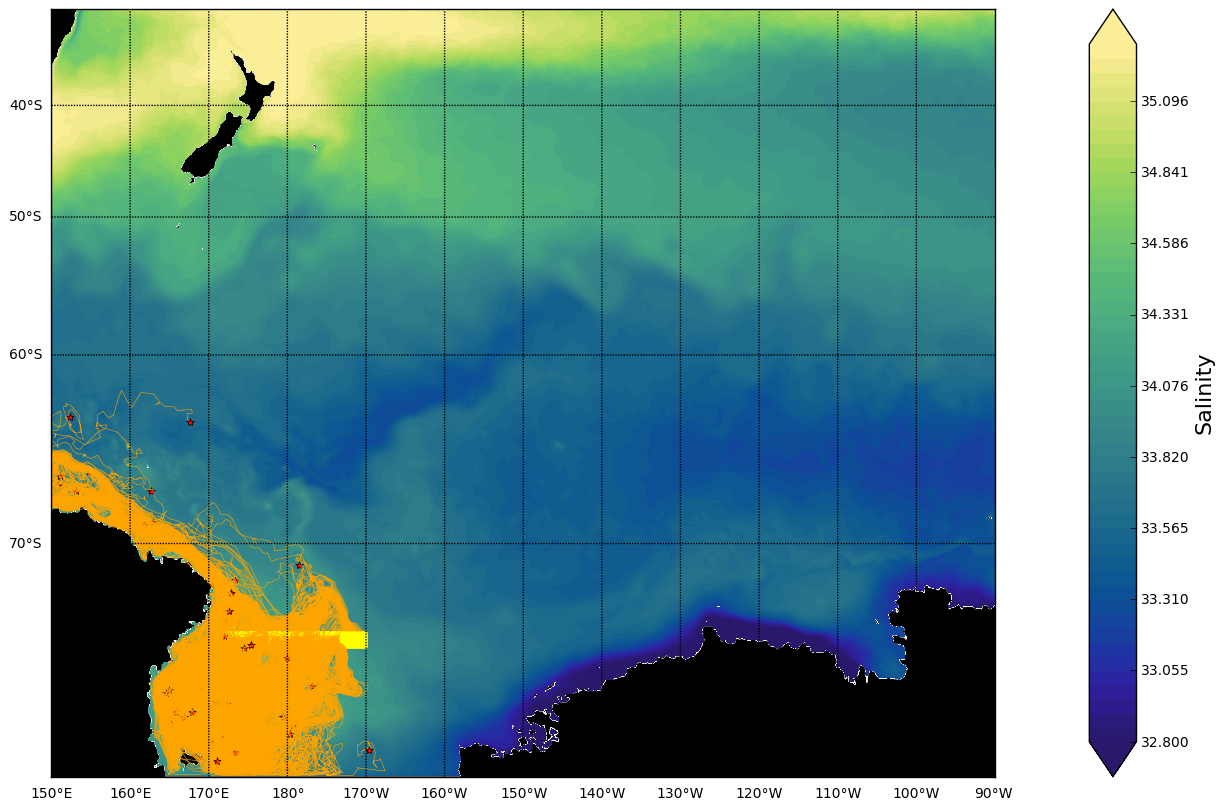

In [14]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(2000,3000), hfacc_level=9)

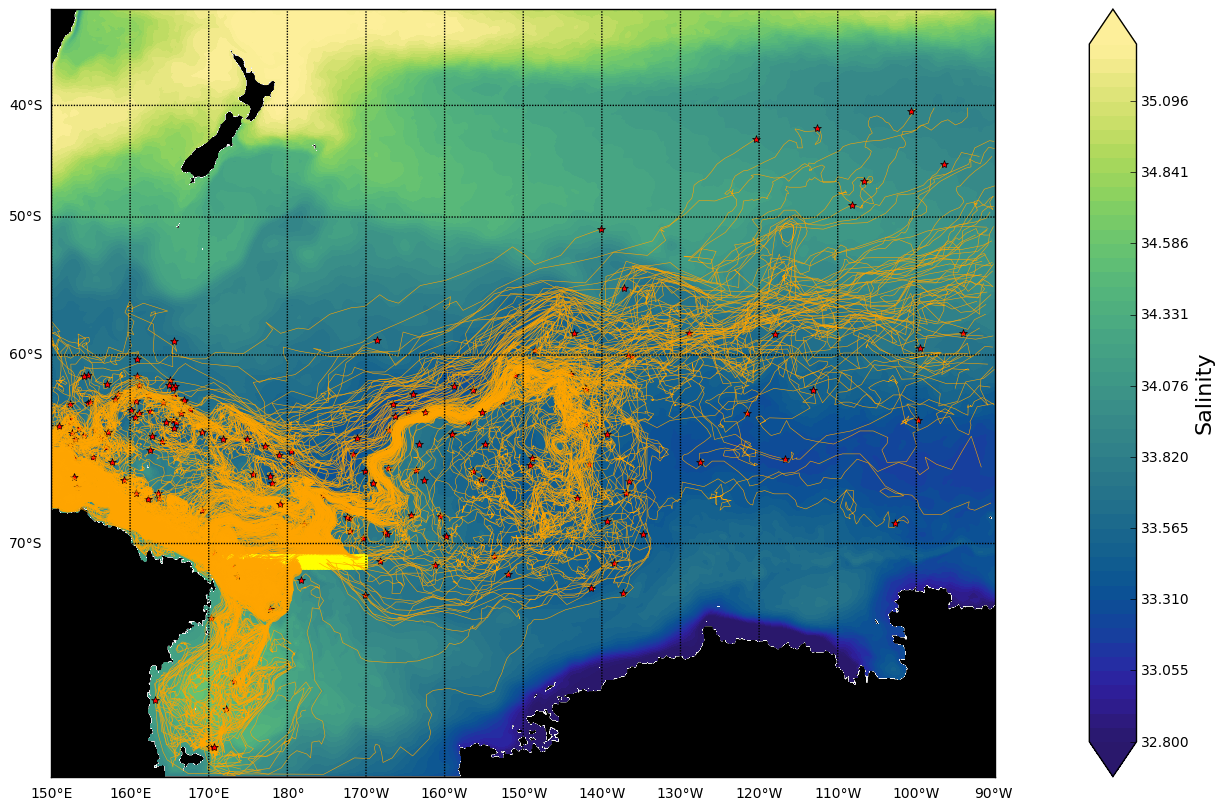

In [15]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(8000,9000), hfacc_level=9)

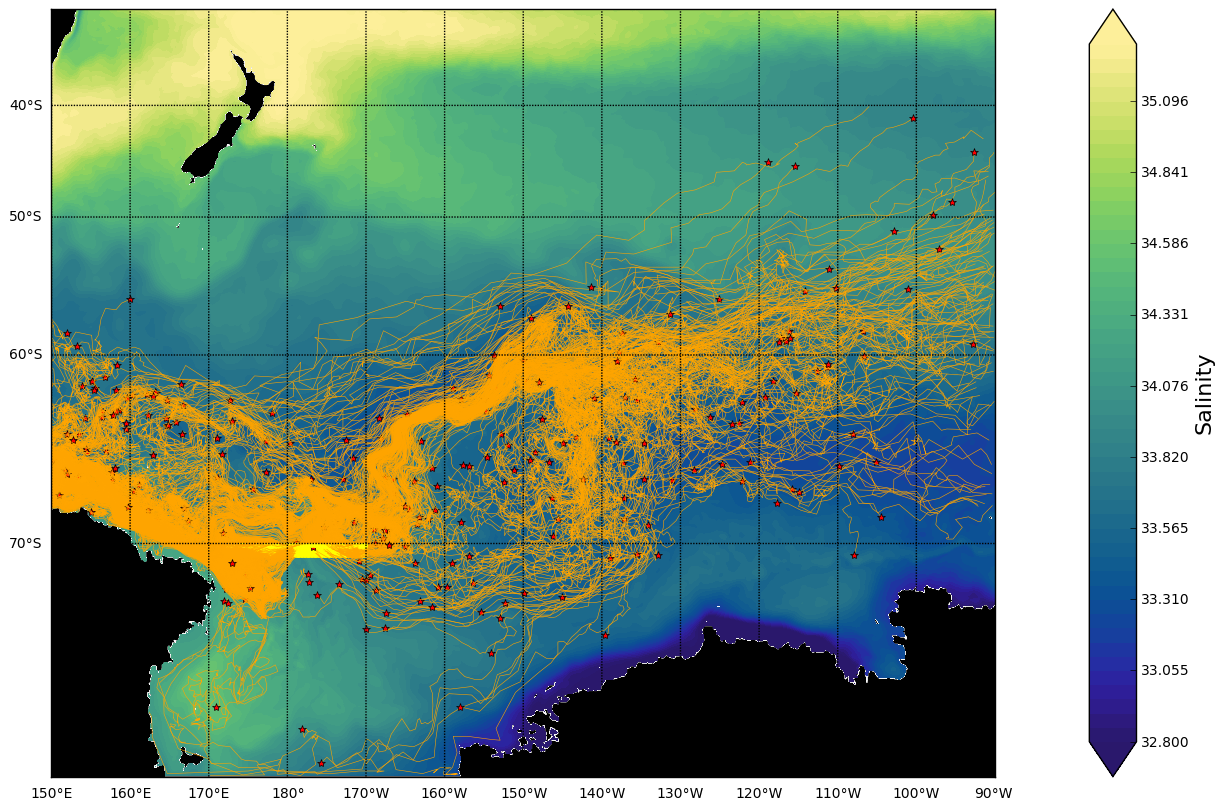

In [16]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(9000,10000), hfacc_level=9)

### Investigating a few particles that go on hfacc==0

/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


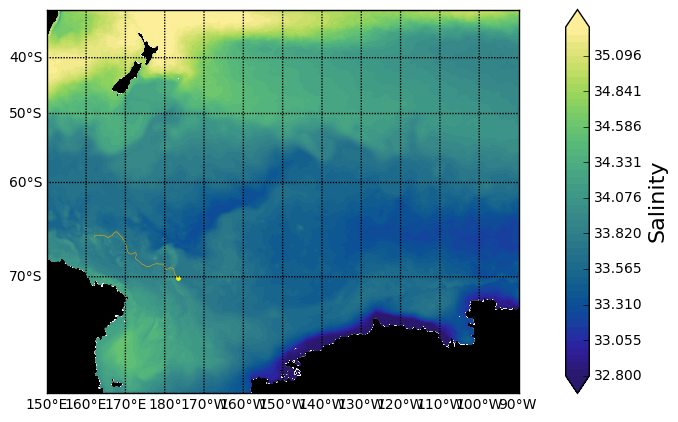

In [24]:
investigate_traj(figsize=(7,5), proj='merc', nb_traj=range(9763, 9764), hfacc_level=9)

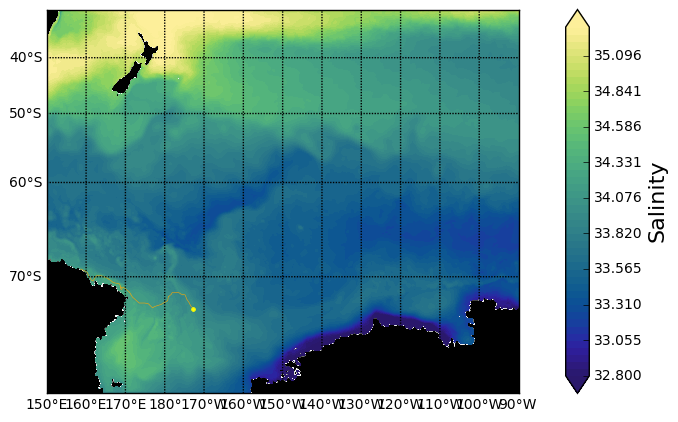

In [25]:
investigate_traj(figsize=(7,5), proj='merc', nb_traj=range(4885, 4886), hfacc_level=17)

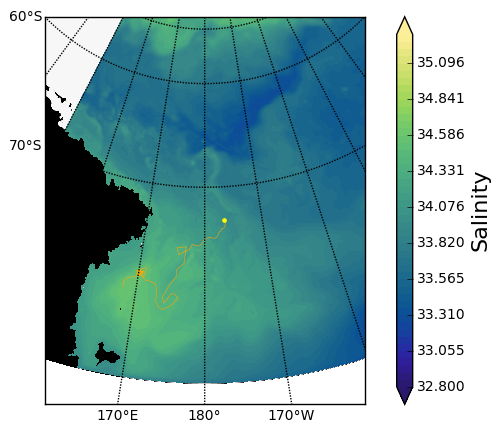

In [26]:
investigate_traj(figsize=(7,5), proj='lamb', nb_traj=range(6163,6164), hfacc_level=54)

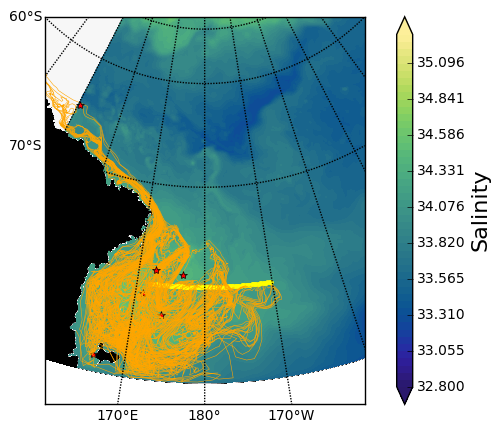

In [27]:
investigate_traj(figsize=(7,5), proj='lamb', nb_traj=range(100), hfacc_level=9)

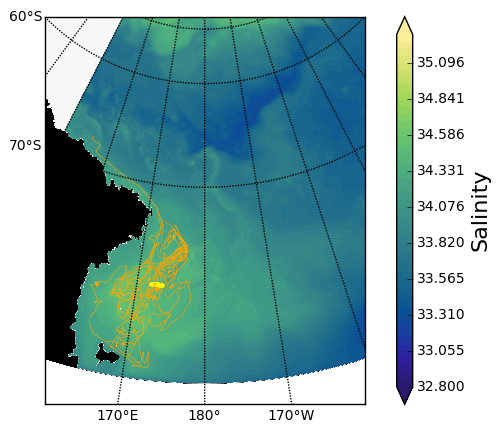

In [28]:
investigate_traj(figsize=(7,5), proj='lamb', nb_traj=range(10), hfacc_level=9)

***

***

# Mettre un mask sur les traj

Il a fallut mettre hFacC sur la même taille que mercator, on l'appelle hfacc

In [12]:
run /home/ebent/Octopus/Octopus-master/scripts/p_xy.py

data has 181 records
glued data : 10_4PARTI_0001_0001.XYZ.0000000001.0000001801.data
location of data : /data/ebent/Octopus/output/10_4parti_2/


Ce run me donne : lon, lat, dep (pos en degrés) et xround, yround, zround (pos en indices dans le domaine du model que j'appelle "bigger domain")

In [13]:
# On selectionne la bonne taille de hFacC == taille de "bigger domain"

load_path2= '/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
file1     = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

lon_min   = 1440 
lon_max   = 3240 # devrait être changé à 3241 si je run ce script again
lat_min   = 0 
lat_max   = 1023 # devrait être changé à 1024 si je run ce script again

YC        = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -40,05
XC        = file1.variables['lon'][lon_min:lon_max] # de 120,04 a 270,04

hfacc = hFacC[:, lat_min:lat_max, lon_min:lon_max]

In [14]:
LON = np.ma.masked_array(lon, mask=False)
LAT = np.ma.masked_array(lat, mask=False)
DEP = np.ma.masked_array(dep, mask=False)

x = np.ma.masked_array(xround, mask=False)
y = np.ma.masked_array(yround, mask=False)
z = np.ma.masked_array(zround, mask=False)

Mettre un mask sur LAT puis LON que l'on reproduira sur les autres variables

In [15]:
# Mask les parti qui sortent du domaine en latitude (sud et nord)

LAT = np.ma.masked_where(LAT < YC[0], LAT) # de -77,99 a -40,05
LAT = np.ma.masked_where(LAT > YC[-1], LAT)

print(YC[-1])

-40.1195716858


In [16]:
LON.mask = LAT.mask

In [17]:
# Mask les parti qui sortent du domaine en longitude (est et ouest)

LON = np.ma.masked_where(LON < XC[0], LON) # de 120,04 a 270,04
LON = np.ma.masked_where(LON > XC[-1], LON)

print(XC[0], XC[-1])

### Here I mask all time steps after the first LON.mask[t,p]==True for each parti

In [18]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué

for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True:
            LON.mask[t:,p]=True
            break
            #print t, p

### Here I put a mask on hfacc==0

In [19]:
for p in range(z.shape[1]):
    for t in range(z.shape[0]):
        if LON.mask[t,p]==True: # changed z ton LON here, should work next time I run it
            continue
        if hfacc[z[t,p], y[t,p], x[t,p]]==0.:
            LON.mask[t:,p]=True

### Here I mask all time steps after the first LON.mask[t,p]==True for each parti AGAIN

In [20]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué

for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True:
            LON.mask[t:,p]=True
            break

#Les deux parti qui sont relous

LON.mask[:,9575] = True
LON.mask[:,8397] = True

On applique le mask de LON pour les autres variables

In [21]:
# Make sure all pos have the same mask
LAT.mask = LON.mask
DEP.mask = LON.mask

x.mask = LON.mask
y.mask = LON.mask
z.mask = LON.mask

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [22]:
path = '/data/ebent/Octopus/output/10_4parti_2/'

pickle_save('DEP_10_4', path, DEP)
pickle_save('LAT_10_4', path, LAT)
pickle_save('LON_10_4', path, LON)

pickle_save('z_10_4', path, z)
pickle_save('y_10_4', path, y)
pickle_save('x_10_4', path, x)

('saved at : ', '/data/ebent/Octopus/output/10_4parti_2/DEP_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/10_4parti_2/LAT_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/10_4parti_2/LON_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/10_4parti_2/z_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/10_4parti_2/y_10_4.npy')
('saved at : ', '/data/ebent/Octopus/output/10_4parti_2/x_10_4.npy')


In [23]:
path = '/data/ebent/Octopus/output/10_4parti_2/'

DEP = pickle_load('DEP_10_4', path, verbose=False)
LAT = pickle_load('LAT_10_4', path, verbose=False)
LON = pickle_load('LON_10_4', path, verbose=False)

z = pickle_load('z_10_4', path, verbose=False)
y = pickle_load('y_10_4', path, verbose=False)
x = pickle_load('x_10_4', path, verbose=False)